In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import json

from prettytable import PrettyTable

# Individual Model Evaluation

In [2]:
evaluation_data = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1_5/checkpoints/converted/epoch=0_test_results.json'

In [3]:
def plot_trigger_scores(data):
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df[['precision', 'recall', 'f1']]
    df = df.reset_index().melt(id_vars=['index'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = [(0, 0.447, 0.698), (0.863, 0.373, 0.294), (0.275, 0.529, 0.204)]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='score', y='value', hue='index', data=df, palette=colors)
    plt.legend(title='Dataset')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Datasets")
    plt.show()

    table = PrettyTable()
    table.field_names = ['Dataset', 'Recall', 'Precision', 'F1']
    for dataset, scores in data.items():
        table.add_row([dataset, float(scores['recall']), float(scores['precision']), float(scores['f1'])])
    print(table)

In [4]:
def plot_auc_scores(data, datasets):
    _, axs = plt.subplots(1, 2, figsize=(16, 6))
    for i, dataset in enumerate(datasets):
        auc_scores_raw = data[dataset]['class_auc']
        auc_scores = {'mean_auc': data[dataset]['auc']}
        auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in auc_scores_raw.items()}

        df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC Score'])
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Class'}, inplace=True)

        sns.set_palette("husl", len(df))
        sns.set(style="darkgrid", palette="husl", rc={"axes.facecolor": (0, 0, 0, 0)})
        sns.barplot(x='Class', y='AUC Score', data=df, ax=axs[i])

        axs[i].axhline(y=0.9828, color='r', linestyle='--', label='Detoxify Baseline (0.9828)')
        axs[i].set(xlabel='Class', ylabel='AUC Score', title=f'AUC Scores per Class for {dataset}')
        axs[i].set_ylim(0.5, 1)
        legend = axs[i].legend(loc='lower right')
        legend.get_frame().set_facecolor('w')

    plt.tight_layout()
    plt.show()

In [5]:
def table_roc_auc_scores(jigsaw_raw, secondary_neutral_raw):
    jigsaw_auc_scores = {'mean_auc': jigsaw_raw['auc']}
    jigsaw_auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in jigsaw_raw['class_auc'].items()}

    secondary_neutral_auc_scores = {'mean_auc': secondary_neutral_raw['auc']}
    secondary_neutral_auc_scores |= {cls: score if not np.isnan(score) else 0 for cls, score in secondary_neutral_raw['class_auc'].items()}
    
    table = PrettyTable()
    table.field_names = ['Class', 'Jigsaw', 'Secondary Neutral']
    for class_label in jigsaw_auc_scores.keys():
        table.add_row([class_label, round(jigsaw_auc_scores[class_label], 4), round(secondary_neutral_auc_scores[class_label], 4)])
    print(table)

In [6]:
def plot_all_data(data):
    plot_trigger_scores(data)
    plot_auc_scores(data, ['jigsaw', 'secondary_neutral'])
    table_roc_auc_scores(data['jigsaw'], data['secondary_neutral'])

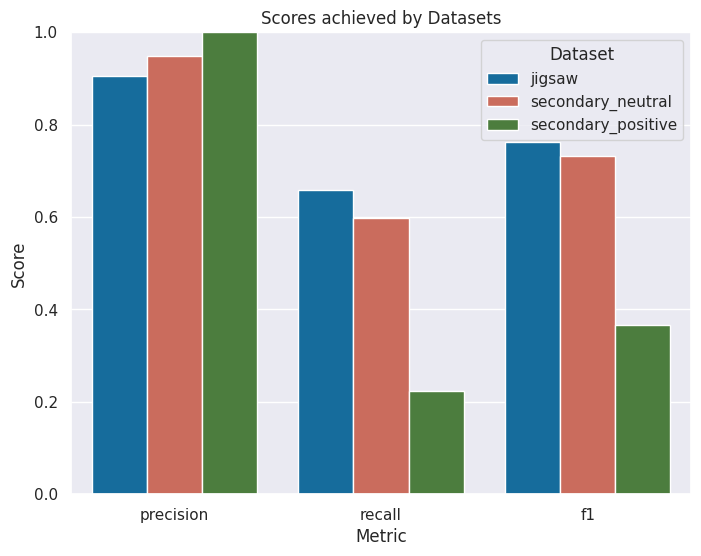

+--------------------+--------+-----------+--------+
|      Dataset       | Recall | Precision |   F1   |
+--------------------+--------+-----------+--------+
|       jigsaw       | 0.6592 |   0.9047  | 0.7627 |
| secondary_neutral  | 0.597  |   0.9487  | 0.7329 |
| secondary_positive | 0.2236 |    1.0    | 0.3655 |
+--------------------+--------+-----------+--------+


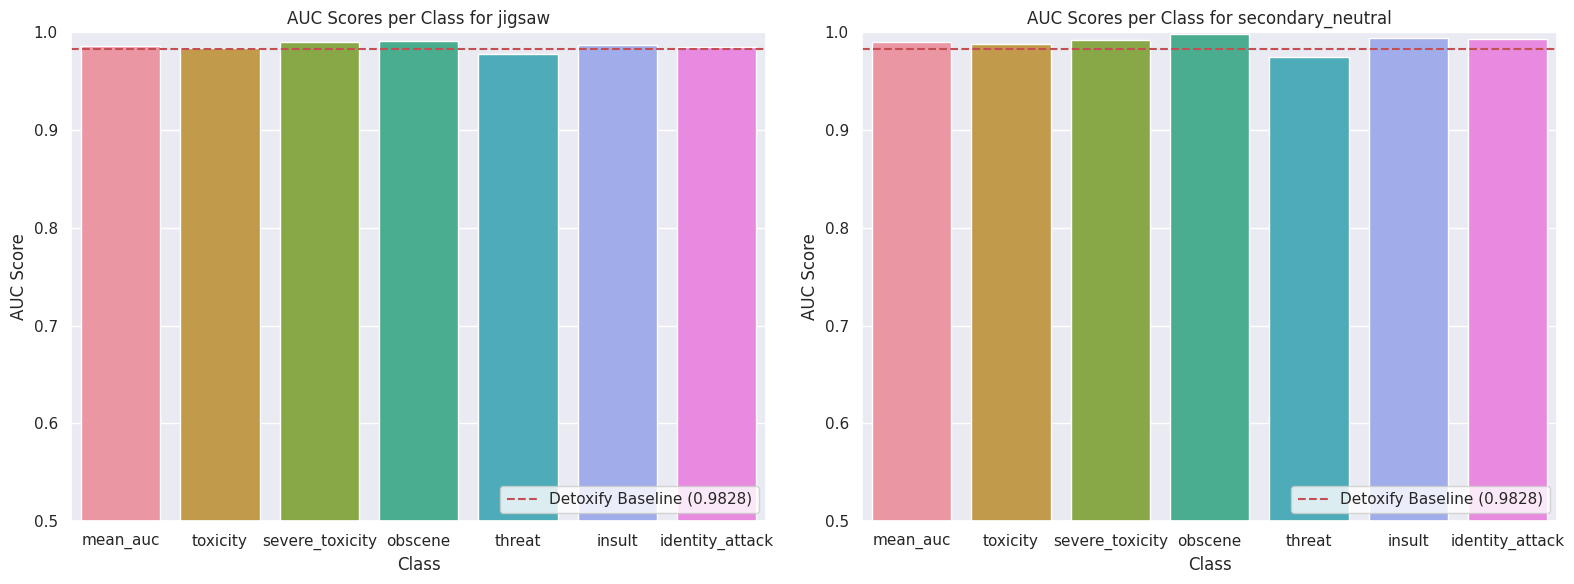

+-----------------+--------+-------------------+
|      Class      | Jigsaw | Secondary Neutral |
+-----------------+--------+-------------------+
|     mean_auc    | 0.9858 |       0.9903      |
|     toxicity    | 0.9839 |       0.988       |
| severe_toxicity |  0.99  |       0.9924      |
|     obscene     | 0.9914 |       0.9987      |
|      threat     | 0.9778 |       0.975       |
|      insult     | 0.9869 |       0.9944      |
| identity_attack | 0.9845 |       0.9934      |
+-----------------+--------+-------------------+


In [7]:
with open(evaluation_data, 'r') as f:
    data = json.load(f)
plot_all_data(data)


In [8]:
def confusion_matrix(confusion_dict):
    table = PrettyTable()
    table.field_names = ['', 'Actual Positive', 'Actual Negative']
    
    table.add_row(['Predicted Positive', confusion_dict['tp'], confusion_dict['fp']])
    table.add_row(['Predicted Negative', confusion_dict['fn'], confusion_dict['tn']])
    
    print(table)

In [9]:
# confusion_matrix_data = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-5-5/checkpoints/converted/epoch=0-step=3279_test_results.json'
# with open(confusion_matrix_data, 'r') as f:
#     data = json.load(f)

# confusion_data = data['secondary_positive']['confusion_matrix']
# confusion_matrix(confusion_data)

# Model Data Ratio Investigation

In [10]:
# ratio_paths = {
#     "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=1_test_results.json',
#     "100:5:5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-5-5/checkpoints/converted/epoch=0-step=3279_test_results.json',
#     "100:10:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-10-10/checkpoints/converted/epoch=0-step=3577_test_results.json',
#     "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=0_test_results.json',
#     "100:100:1-5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1_5/checkpoints/converted/epoch=2_test_results.json',
#     "100:100:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-10/checkpoints/converted/epoch=0_test_results.json',
#     "100:100:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-50/checkpoints/converted/epoch=0_test_results.json',
#     "100:100:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-100/checkpoints/converted/epoch=0-step=8942_test_results.json',
#     "100:200:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results.json',
#     "100:200:50-5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-50/checkpoints/converted/epoch=3_test_results.json',
#     "100:200:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-100/checkpoints/converted/epoch=0_test_results.json'
# }

ratio_paths = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=1_test_results.json',
    '100:5:5': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-5-5/checkpoints/converted/epoch=0_test_results.json',
    '100:10:10': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-10-10/checkpoints/converted/epoch=0_test_results.json',
    '100:10:20': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-10-20/checkpoints/converted/epoch=0_test_results.json',
    '100:100:1-2': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1_5/checkpoints/converted/epoch=2_test_results.json',
    '100:100:10': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-10/checkpoints/converted/epoch=0_test_results.json',
    '100:100:50': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-50/checkpoints/converted/epoch=0_test_results.json',
    '100:100:100': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-100/checkpoints/converted/epoch=0_test_results.json',
    '100:200:50-3': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-50_5/checkpoints/converted/epoch=3_test_results.json',
    '100:200:100': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-100_3/checkpoints/converted/epoch=0_test_results.json',
}

In [11]:
def plot_ratio_scores(df, dataset):
    df_melt = df.melt(id_vars=['Ratio'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = sns.color_palette("bright", n_colors=len(df_melt['Ratio'].unique()))

    g = sns.catplot(x='score', y='value', hue='Ratio', data=df_melt, kind='bar', palette=colors,
                sharey=False, aspect=1.5, height=6, errorbar=None)
    g.set_axis_labels("", "Score")
    g.set_xticklabels(ha="right")
    g._legend.remove()

    plt.legend(title='Dataset Ratios', loc='center right', bbox_to_anchor=(1.2, 0.5))
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title(f"{dataset} Scores achieved by Different Dataset Ratios - Jigsaw:Secondary Neutral:Secondary Positive")
    plt.show()

    # create a table of the results
    table = PrettyTable()
    table.field_names = ['Ratio', 'Precision', 'Recall', 'F1']
    for _, row in df.iterrows():
        table.add_row([row['Ratio'], row['Precision'], row['Recall'], row['F1']])
    # print(table)

In [12]:
dataset = 'jigsaw'
dataset = 'secondary_neutral'
# dataset = 'secondary_positive'
dataset_name = " ".join([w[0].upper() + w[1:] for w in dataset.split("_")])
final_df = pd.DataFrame()
for ratio, json_path in ratio_paths.items():
    with open(json_path, 'r') as f:
        data = json.load(f)[dataset]
        df = pd.DataFrame.from_dict(data, orient='index').transpose()
        df = df.loc[:, ['precision', 'recall', 'f1']]
        df['ratio'] = ratio
        final_df = pd.concat([final_df, df], ignore_index=True)
final_df = final_df.rename(columns={
    'recall': 'Recall',
    'precision': 'Precision',
    'f1': 'F1',
    'ratio': 'Ratio'
})

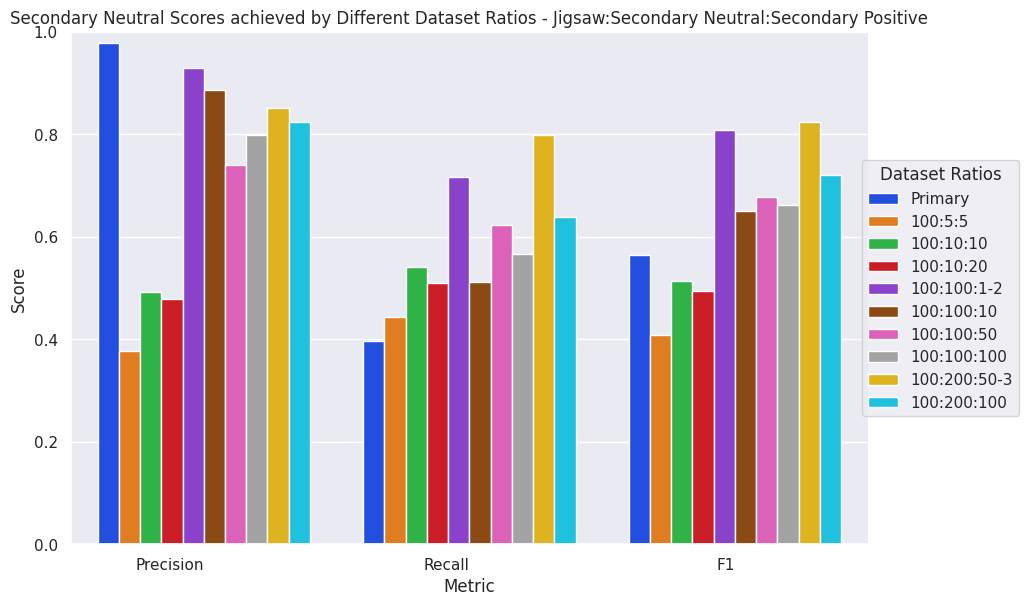

In [13]:
plot_ratio_scores(final_df, dataset=dataset_name)


In [14]:
def create_final_df(result_paths, first_row):
    datasets = [("jigsaw", "J"), ("secondary_neutral", "SN"), ("secondary_positive", "SP")]
    final_df = pd.DataFrame(columns=[first_row, "Precision (J)", "Recall (J)", "F1 (J)", "Precision (SN)",
                            "Recall (SN)", "F1 (SN)", "Precision (SP)", "Recall (SP)", "F1 (SP)"])
    for id, json_path in result_paths.items():
        with open(json_path, 'r') as f:
            data = json.load(f)
            new_row = {
                first_row: id,
            }
            for (dataset, acronym) in datasets:
                d = data[dataset]
                new_row |= {
                    f"Precision ({acronym})": "{:1.4f}".format(d['precision']),
                    f"Recall ({acronym})": "{:1.4f}".format(d['recall']),
                    f"F1 ({acronym})": "{:1.4f}".format(d['f1'])
                }

        final_df = pd.concat(
            [final_df, pd.DataFrame([new_row])], ignore_index=True)

    final_df['DPS'] = 0.4 * final_df['F1 (J)'].astype(float) + 0.4 * final_df['F1 (SN)'].astype(float) + 0.2 * final_df['F1 (SP)'].astype(float)
    final_df['DPS'] = final_df['DPS'].map('{:1.4f}'.format)
    return final_df



In [15]:
def table_ratio_results(table_data):
    table = PrettyTable()
    table.field_names = ['Ratio', "Precision (J)", "Recall (J)", "F1 (J)", "Precision (SN)",
                         "Recall (SN)", "F1 (SN)", "Precision (SP)", "Recall (SP)", "F1 (SP)", "DPS"]
    for _, row in table_data.iterrows():
        table.add_row([
            row['Ratio'],
            row['Precision (J)'],
            row['Recall (J)'],
            row['F1 (J)'],
            row['Precision (SN)'],
            row['Recall (SN)'],
            row['F1 (SN)'],
            row['Precision (SP)'],
            row['Recall (SP)'],
            row['F1 (SP)'],
            row['DPS']
        ])
    print("Scores achieved by the three datasets: Jigsaw - Secondary Neutral - Secondary Positive")
    print(table)
    print("Key: J = Jigsaw | SN = Secondary Neutral | SP = Secondary Positive")

In [16]:
def highlight_extremes(s):
    if s.name == "Ratio" or s.name == "Model" or s.name == "Precision (SP)":
        return ['' for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
        is_min = s == s.min()
        if is_max.iloc[0]:
            is_max.iloc[0] = False
            sorted_values = s.iloc[1:].sort_values(ascending=False)
            if not sorted_values.empty:
                second_max_index = sorted_values.index[0]
                is_max.loc[second_max_index] = True
        if is_min.iloc[0]:
            is_min.iloc[0] = False
            sorted_values = s.iloc[1:].sort_values()
            if not sorted_values.empty:
                second_min_index = sorted_values.index[0]
                is_min.loc[second_min_index] = True
        return [
            'background: teal' if cell_max else 'background: #D16C6C' if cell_min else ''
            for cell_max, cell_min in zip(is_max, is_min)
        ]

In [17]:
def highlight_extremes_triples(s):
    if s.name == "Ratio" or s.name == "Model" or s.name == "Precision (SP)":
        return ['' for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
        is_min = s == s.min()
        is_max[0] = False  # Exclude the first row from highlighting
        is_min[0] = False  # Exclude the first row from highlighting
        
        for i in range(1, len(s), 3):
            section_max = s.iloc[i:i+3].max()
            section_min = s.iloc[i:i+3].min()
            
            if not pd.isnull(section_max):
                is_max.iloc[i:i+3] |= (s.iloc[i:i+3] == section_max)
                
            if not pd.isnull(section_min):
                is_min.iloc[i:i+3] |= (s.iloc[i:i+3] == section_min)
                
        return [
            'background: teal' if cell_max else 'background: #D16C6C' if cell_min else ''
            for cell_max, cell_min in zip(is_max, is_min)
        ]


In [18]:
ratio_df = create_final_df(ratio_paths, "Ratio")
ratio_df.style.apply(highlight_extremes)


,Ratio,Precision (J),Recall (J),F1 (J),Precision (SN),Recall (SN),F1 (SN),Precision (SP),Recall (SP),F1 (SP),DPS
0,Primary,0.9181,0.6525,0.7628,0.9791,0.3977,0.5656,0.0000,0.0000,0.0000,0.5314
1,100:5:5,0.9141,0.6386,0.7519,0.3780,0.4430,0.4080,1.0000,0.9643,0.9818,0.6603
2,100:10:10,0.9099,0.6561,0.7624,0.4915,0.5403,0.5147,1.0000,0.9563,0.9777,0.7064
3,100:10:20,0.9067,0.6399,0.7503,0.4790,0.5104,0.4942,1.0000,0.9722,0.9859,0.6950
4,100:100:1-2,0.9093,0.6731,0.7735,0.9292,0.7165,0.8091,1.0000,0.3052,0.4676,0.7266
5,100:100:10,0.9113,0.6350,0.7485,0.8877,0.5127,0.6500,1.0000,0.6956,0.8204,0.7235
6,100:100:50,0.8992,0.6391,0.7471,0.7410,0.6233,0.6771,1.0000,0.9716,0.9856,0.7668
7,100:100:100,0.9164,0.6140,0.7353,0.7986,0.5658,0.6624,1.0000,0.8016,0.8899,0.7371
8,100:200:50-3,0.9086,0.6852,0.7812,0.8508,0.7994,0.8243,1.0000,0.9563,0.9777,0.8377
9,100:200:100,0.9072,0.6171,0.7345,0.8243,0.6394,0.7202,1.0000,0.9403,0.9692,0.7757


In [19]:
topic_ratio_paths = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=1_test_results.json',
    'Topic 4 - 100:100:1': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-100-1/checkpoints/converted/epoch=0_test_results.json',
    'Topic 4 - 100:200:50': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results.json',
    'Topic 4 - 100:200:100': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-200-100/checkpoints/converted/epoch=0_test_results.json',
    'Topic 6 - 100:100:1': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1_5/checkpoints/converted/epoch=2_test_results.json',
    'Topic 6 - 100:200:50': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-50_5/checkpoints/converted/epoch=3_test_results.json',
    'Topic 6 - 100:200:100': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-100_3/checkpoints/converted/epoch=0_test_results.json',
    'Topic 7 - 100:100:1': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-7/lightning_logs/blank-100-1/checkpoints/converted/epoch=0_test_results.json',
    'Topic 7 - 100:200:50': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-7/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results.json',
    'Topic 7 - 100:200:100': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-7/lightning_logs/blank-200-100/checkpoints/converted/epoch=0_test_results.json',
    'Topic 10 - 100:100:1': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-100-1/checkpoints/converted/epoch=0_test_results.json',
    'Topic 10 - 100:200:50': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results.json',
    'Topic 10 - 100:200:100': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-200-100/checkpoints/converted/epoch=0_test_results.json',
}

In [20]:
topic_ratio_df = create_final_df(topic_ratio_paths, "Ratio")
topic_ratio_df.style.apply(highlight_extremes_triples)

,Ratio,Precision (J),Recall (J),F1 (J),Precision (SN),Recall (SN),F1 (SN),Precision (SP),Recall (SP),F1 (SP),DPS
0,Primary,0.9181,0.6525,0.7628,0.9791,0.3977,0.5656,0.0000,0.0000,0.0000,0.5314
1,Topic 4 - 100:100:1,0.9142,0.6059,0.7288,0.9561,0.4896,0.6476,1.0000,0.1941,0.3252,0.6156
2,Topic 4 - 100:200:50,0.9137,0.6399,0.7527,0.9178,0.5991,0.7250,1.0000,0.9762,0.9880,0.7887
3,Topic 4 - 100:200:100,0.9122,0.6189,0.7375,0.9082,0.6608,0.7650,1.0000,0.9560,0.9775,0.7965
4,Topic 6 - 100:100:1,0.9093,0.6731,0.7735,0.9292,0.7165,0.8091,1.0000,0.3052,0.4676,0.7266
5,Topic 6 - 100:200:50,0.9086,0.6852,0.7812,0.8508,0.7994,0.8243,1.0000,0.9563,0.9777,0.8377
6,Topic 6 - 100:200:100,0.9072,0.6171,0.7345,0.8243,0.6394,0.7202,1.0000,0.9403,0.9692,0.7757
7,Topic 7 - 100:100:1,0.9136,0.6064,0.7289,0.8979,0.5625,0.6917,1.0000,0.5642,0.7214,0.7125
8,Topic 7 - 100:200:50,0.9147,0.6288,0.7452,0.9168,0.5914,0.7189,1.0000,0.8807,0.9366,0.7730
9,Topic 7 - 100:200:100,0.9062,0.6319,0.7446,0.9243,0.6445,0.7594,1.0000,0.8440,0.9154,0.7847


# Primary vs Secondary Model Investigation

In [24]:
# topic_paths = {
#     "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=1_test_results.json',
#     'Topic 4': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results.json',
#     'Topic 6': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-50_5/checkpoints/converted/epoch=3_test_results.json',
#     'Topic 7': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-7/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results.json',
#     'Topic 10': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-200-50/checkpoints/converted/epoch=0_test_results.json',
# }
topic_paths = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=1_test_results.json',
    'Topic 4': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-200-100/checkpoints/converted/epoch=0_test_results.json',
    'Topic 6': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-200-50_5/checkpoints/converted/epoch=3_test_results.json',
    'Topic 7': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-7/lightning_logs/blank-200-100/checkpoints/converted/epoch=0_test_results.json',
    'Topic 10': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-100-1/checkpoints/converted/epoch=0_test_results.json',
}

In [25]:
def compare_primary_secondary(df):
    df_melt = df.melt(id_vars=['Model'], var_name='score', value_name='value')
    df_melt['value'] = pd.to_numeric(df_melt['value'])

    sns.set(style="darkgrid")
    colors = sns.color_palette("husl", n_colors=len(df_melt['Model'].unique()))

    g = sns.catplot(x='score', y='value', hue='Model', data=df_melt, kind='bar', palette=colors,
                    sharey=False, aspect=2, height=6, errorbar=None, dodge=True)

    # Add vertical dotted line every 3 groups of bars
    for i in range(3, len(df_melt['score'].unique()), 3):
        plt.axvline(x=i-0.5, linestyle='--', color='gray')

    g.set_axis_labels("", "Score")
    g.set_xticklabels(ha="right")
    g._legend.remove()

    plt.legend(title='Models', loc='center right', bbox_to_anchor=(1.12, 0.5))
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Models")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


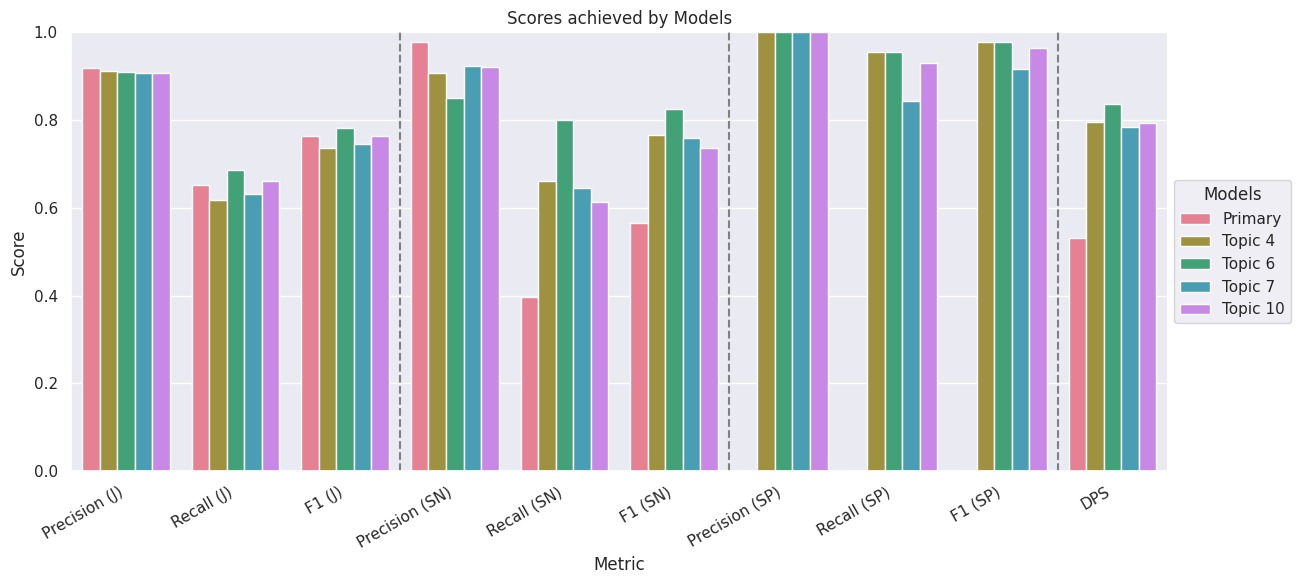

,Model,Precision (J),Recall (J),F1 (J),Precision (SN),Recall (SN),F1 (SN),Precision (SP),Recall (SP),F1 (SP),DPS
0,Primary,0.9181,0.6525,0.7628,0.9791,0.3977,0.5656,0.0000,0.0000,0.0000,0.5314
1,Topic 4,0.9122,0.6189,0.7375,0.9082,0.6608,0.7650,1.0000,0.9560,0.9775,0.7965
2,Topic 6,0.9086,0.6852,0.7812,0.8508,0.7994,0.8243,1.0000,0.9563,0.9777,0.8377
3,Topic 7,0.9062,0.6319,0.7446,0.9243,0.6445,0.7594,1.0000,0.8440,0.9154,0.7847
4,Topic 10,0.9066,0.6610,0.7646,0.9199,0.6130,0.7357,1.0000,0.9302,0.9639,0.7929


In [26]:
topic_df = create_final_df(topic_paths, "Model")
compare_primary_secondary(topic_df)
topic_df.style.apply(highlight_extremes)

In [33]:
import os
import json
import argparse
import numpy as np
import torch
import numpy as np
import multiprocessing
import warnings

In [37]:
checkpoint_path = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_5/checkpoints/converted/epoch=0-step=5588.ckpt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
config1 = checkpoint["config"]
print(config1)

{'name': 'ALBERT-Clean', 'n_gpu': 2, 'batch_size': 16, 'accumulate_grad_batches': 1, 'loss': 'binary_cross_entropy', 'arch': {'type': 'ALBERT', 'args': {'num_classes': 6, 'model_type': 'albert-base-v2', 'model_name': 'AlbertForSequenceClassification', 'tokenizer_name': 'AlbertTokenizer'}, 'freeze_bert': False, 'from_detoxify': False}, 'dataset': {'type': 'JigsawData', 'args': {'train': {'secondary_positive': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/train_secondary_positive.csv', 'secondary_neutral': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/train_secondary_neutral.csv', 'jigsaw': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/train_jigsaw.csv'}, 'val': {'secondary_positive': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/val_secondary_positive.csv', 'secondary_neutral': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-m

In [38]:
checkpoint_path = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_7/checkpoints/converted/epoch=0-step=8.ckpt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
config2 = checkpoint["config"]
print(config2)

{'name': 'ALBERT-Clean', 'n_gpu': 2, 'batch_size': 16, 'accumulate_grad_batches': 1, 'loss': 'binary_cross_entropy', 'arch': {'type': 'ALBERT', 'args': {'num_classes': 6, 'model_type': 'albert-base-v2', 'model_name': 'AlbertForSequenceClassification', 'tokenizer_name': 'AlbertTokenizer'}, 'freeze_bert': False, 'from_detoxify': False}, 'dataset': {'type': 'JigsawData', 'args': {'train': {'secondary_positive': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/train_secondary_positive.csv', 'secondary_neutral': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/train_secondary_neutral.csv', 'jigsaw': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/train_jigsaw.csv'}, 'val': {'secondary_positive': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/val_secondary_positive.csv', 'secondary_neutral': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-m

In [39]:
checkpoint_path = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Clean/lightning_logs/version_8/checkpoints/converted/epoch=0.ckpt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
config3 = checkpoint["config"]
print(config3)

{'name': 'ALBERT-Clean', 'n_gpu': 2, 'batch_size': 16, 'accumulate_grad_batches': 1, 'loss': 'binary_cross_entropy', 'arch': {'type': 'ALBERT', 'args': {'num_classes': 6, 'model_type': 'albert-base-v2', 'model_name': 'AlbertForSequenceClassification', 'tokenizer_name': 'AlbertTokenizer'}, 'freeze_bert': False, 'from_detoxify': False}, 'dataset': {'type': 'JigsawData', 'args': {'train': {'secondary_positive': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/train_secondary_positive.csv', 'secondary_neutral': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/train_secondary_neutral.csv', 'jigsaw': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/train_jigsaw.csv'}, 'val': {'secondary_positive': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/val_secondary_positive.csv', 'secondary_neutral': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-m

In [40]:
config1 == config2

True

In [41]:
config2 == config3

True